# Preparation

In [21]:
# system imports
import os
import sys

# data science
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import seaborn as sns

# signal processing
from scipy import signal
from scipy.ndimage import label
from scipy.stats import zscore
from scipy.interpolate import interp1d
from scipy.integrate import trapz

# misc
import warnings

In [22]:
data = pd.read_excel("../9_plotting_report/HR_compilation.xlsx")
data.head()

,Time,HR,RR,MS,SKINCONTACT,experiment_set,experiment_id,subid,Thermal,Traffic noise levels,Speech
0,2023-07-10 10:45:00.613,73,795,0.025007,1,1,1,1,NV fan 5,55,0
1,2023-07-10 10:45:01.432,73,819,0.025017,1,1,1,1,NV fan 5,55,0
2,2023-07-10 10:45:02.281,74,849,0.025026,1,1,1,1,NV fan 5,55,0
3,2023-07-10 10:45:03.157,73,876,0.025037,1,1,1,1,NV fan 5,55,0
4,2023-07-10 10:45:03.985,73,828,0.025046,1,1,1,1,NV fan 5,55,0


In [23]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 671111 entries, 0 to 671110
Data columns (total 11 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   Time                  671111 non-null  datetime64[ns]
 1   HR                    671111 non-null  int64         
 2   RR                    671111 non-null  int64         
 3   MS                    671111 non-null  float64       
 4   SKINCONTACT           671111 non-null  int64         
 5   experiment_set        671111 non-null  int64         
 6   experiment_id         671111 non-null  int64         
 7   subid                 671111 non-null  int64         
 8   Thermal               671111 non-null  object        
 9   Traffic noise levels  671111 non-null  int64         
 10  Speech                671111 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(8), object(1)
memory usage: 56.3+ MB


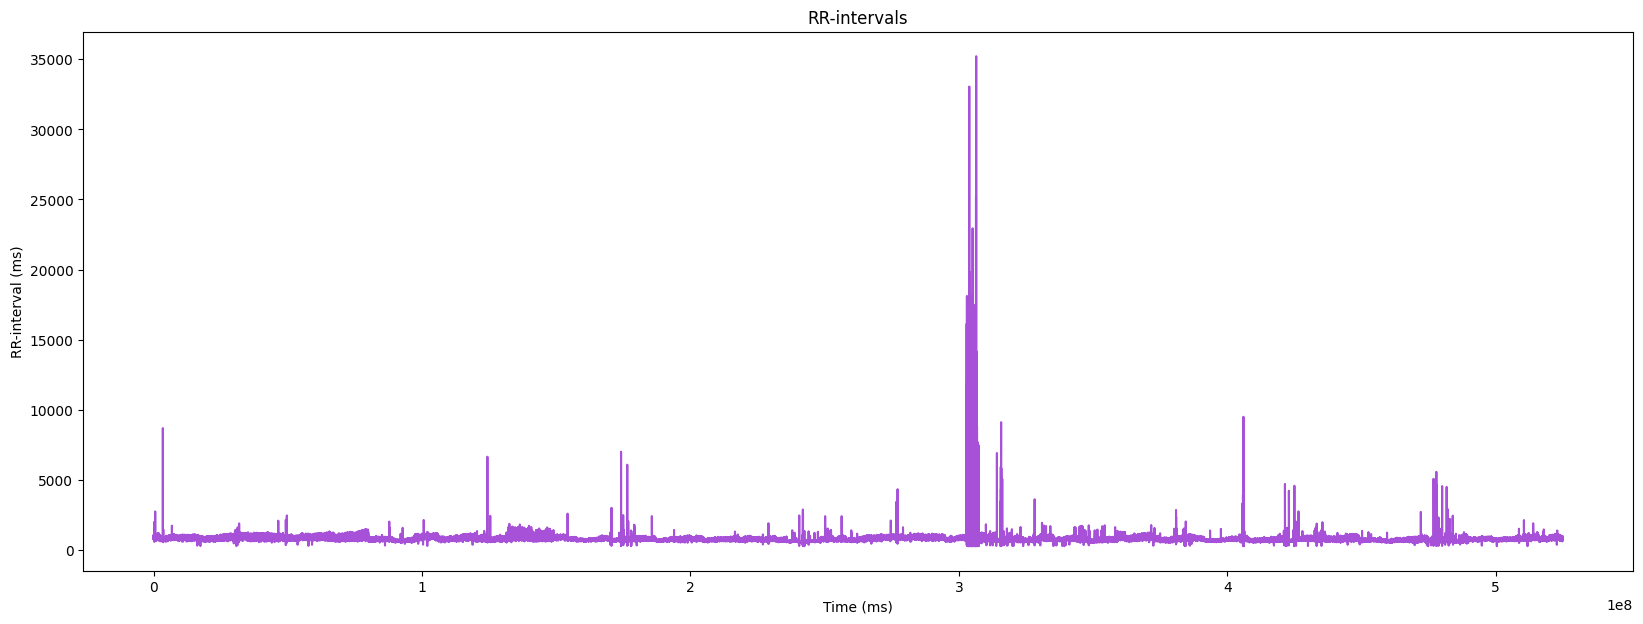

In [24]:
# plot RR-intervals
plt.figure(figsize=(20, 7))
plt.title("RR-intervals")
plt.xlabel("Time (ms)")
plt.ylabel("RR-interval (ms)")

plt.plot(np.cumsum(data.RR), data.RR, label="RR-interval", color="#A651D8")
plt.show()

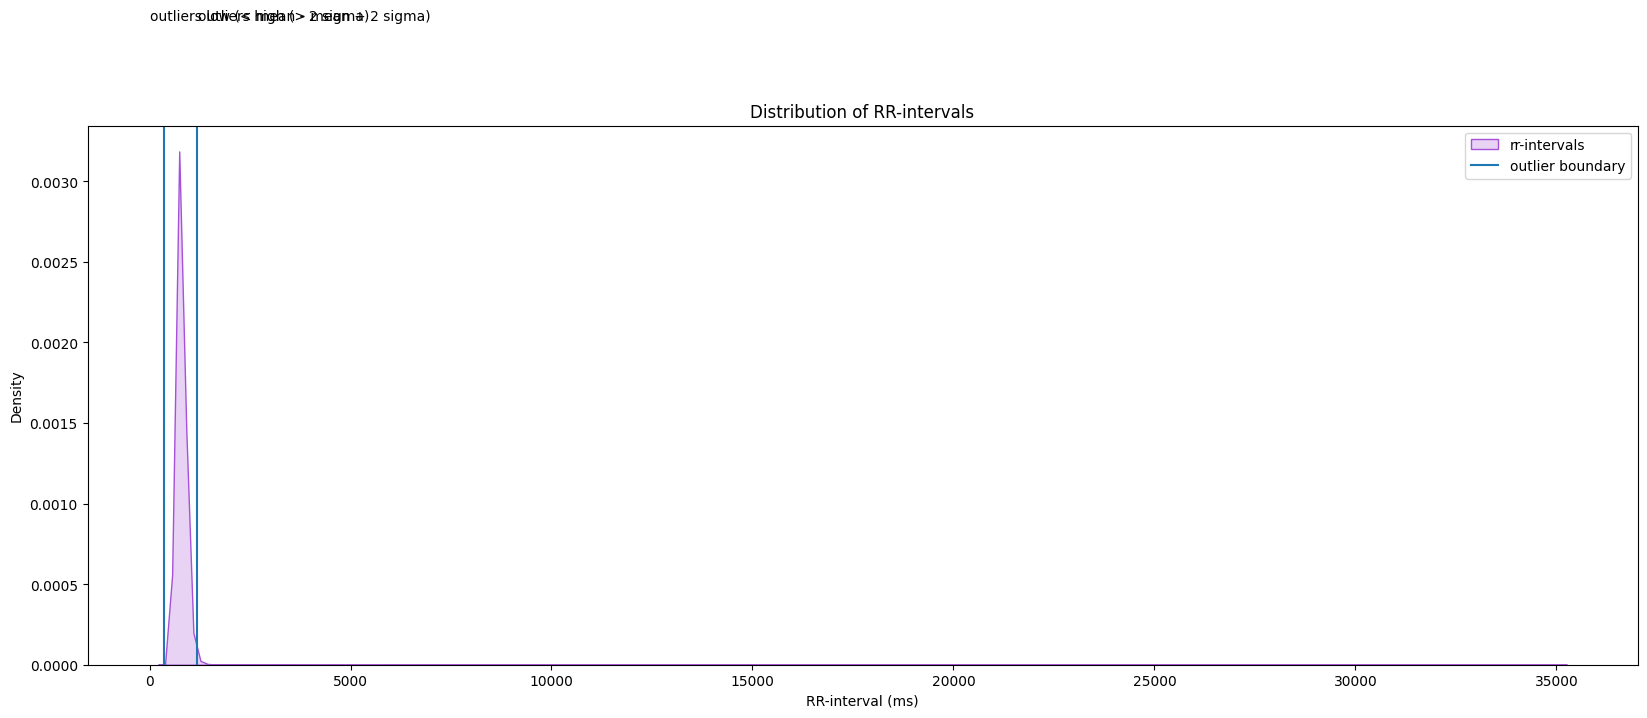

In [25]:
plt.figure(figsize=(20, 7))
plt.title("Distribution of RR-intervals")

with warnings.catch_warnings():
    warnings.simplefilter("ignore") # ignore FutureWarning 
    sns.kdeplot(data.RR, label="rr-intervals", color="#A651D8", shade=True)

outlier_low = np.mean(data.RR) - 2 * np.std(data.RR)
outlier_high = np.mean(data.RR) + 2 * np.std(data.RR)

plt.axvline(x=outlier_low)
plt.axvline(x=outlier_high, label="outlier boundary")
plt.text(outlier_low - 370, 0.004, "outliers low (< mean - 2 sigma)")
plt.text(outlier_high + 20, 0.004, "outliers high (> mean + 2 sigma)")

plt.xlabel("RR-interval (ms)")
plt.ylabel("Density")

plt.legend()
plt.show()

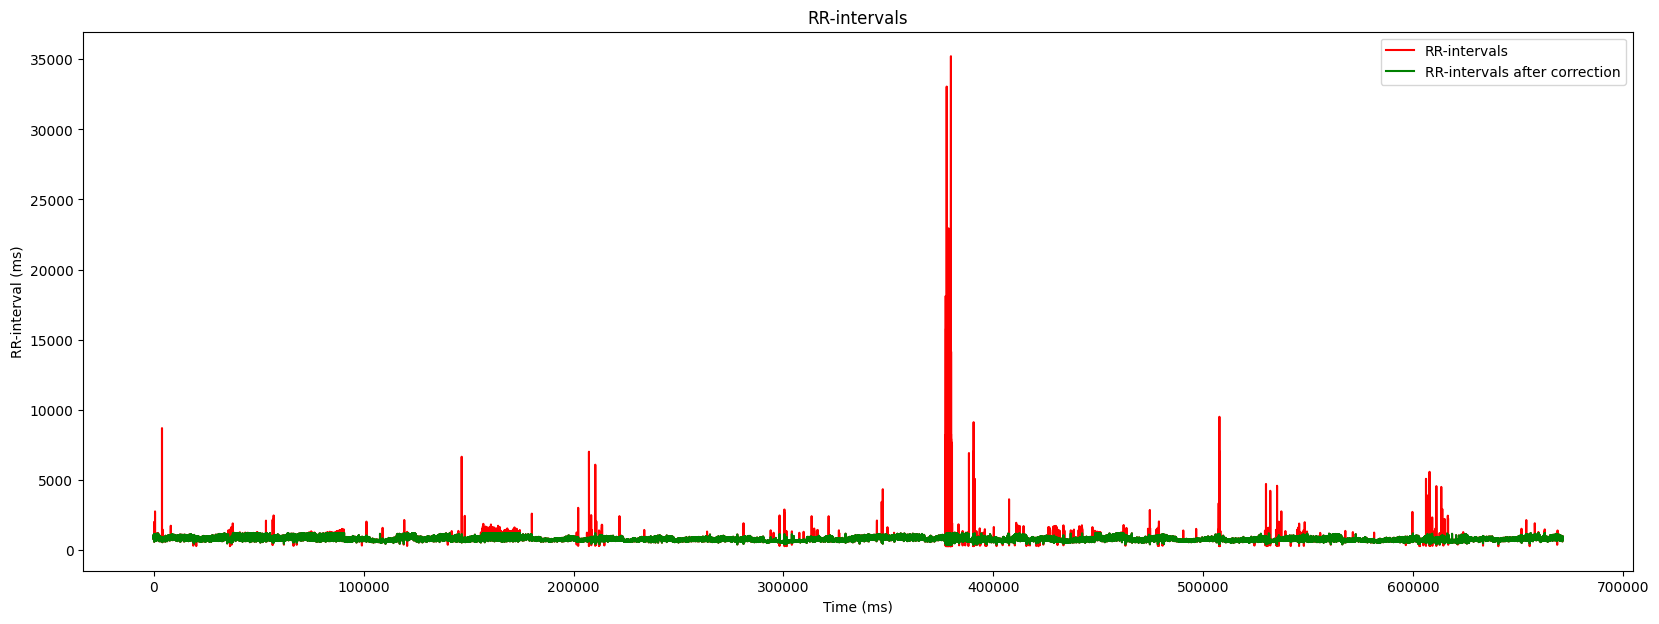

In [26]:
plt.figure(figsize=(20, 7))

rr_corrected = data.RR.copy()
rr_corrected[np.abs(zscore(data.RR)) > 2] = np.median(data.RR)

plt.title("RR-intervals")
plt.xlabel("Time (ms)")
plt.ylabel("RR-interval (ms)")

plt.plot(data.RR, color="red", label="RR-intervals")
plt.plot(rr_corrected, color="green",  label="RR-intervals after correction")
plt.legend()
plt.show()

# Time Domain Analysis

In [27]:
def timedomain(rr):
    results = {}

    hr = 60000/rr
    
    results['Mean RR (ms)'] = np.mean(rr)
    results['STD RR/SDNN (ms)'] = np.std(rr)
    results['Mean HR (Kubios\' style) (beats/min)'] = 60000/np.mean(rr)
    results['Mean HR (beats/min)'] = np.mean(hr)
    results['STD HR (beats/min)'] = np.std(hr)
    results['Min HR (beats/min)'] = np.min(hr)
    results['Max HR (beats/min)'] = np.max(hr)
    results['RMSSD (ms)'] = np.sqrt(np.mean(np.square(np.diff(rr))))
    results['NNxx'] = np.sum(np.abs(np.diff(rr)) > 50)*1
    results['pNNxx (%)'] = 100 * np.sum((np.abs(np.diff(rr)) > 50)*1) / len(rr)
    return results

In [28]:
print("Time domain metrics - automatically corrected RR-intervals:")
for k, v in timedomain(data.RR).items():
    print("- %s: %.2f" % (k, v))

print()
print("Time domain metrics - manually corrected RR-intervals:")
for k, v in timedomain(rr_corrected).items():
    print("- %s: %.2f" % (k, v))

Time domain metrics - automatically corrected RR-intervals:
- Mean RR (ms): 782.25
- STD RR/SDNN (ms): 205.76
- Mean HR (Kubios' style) (beats/min): 76.70
- Mean HR (beats/min): 79.07
- STD HR (beats/min): 13.15
- Min HR (beats/min): 1.70
- Max HR (beats/min): 237.15
- RMSSD (ms): 189.05
- NNxx: 106858.00
- pNNxx (%): 15.92

Time domain metrics - manually corrected RR-intervals:
- Mean RR (ms): 775.92
- STD RR/SDNN (ms): 121.74
- Mean HR (Kubios' style) (beats/min): 77.33
- Mean HR (beats/min): 79.22
- STD HR (beats/min): 12.32
- Min HR (beats/min): 50.29
- Max HR (beats/min): 161.73
- RMSSD (ms): 48.67
- NNxx: 105170.00
- pNNxx (%): 15.67


# Frequency Domain Analysis

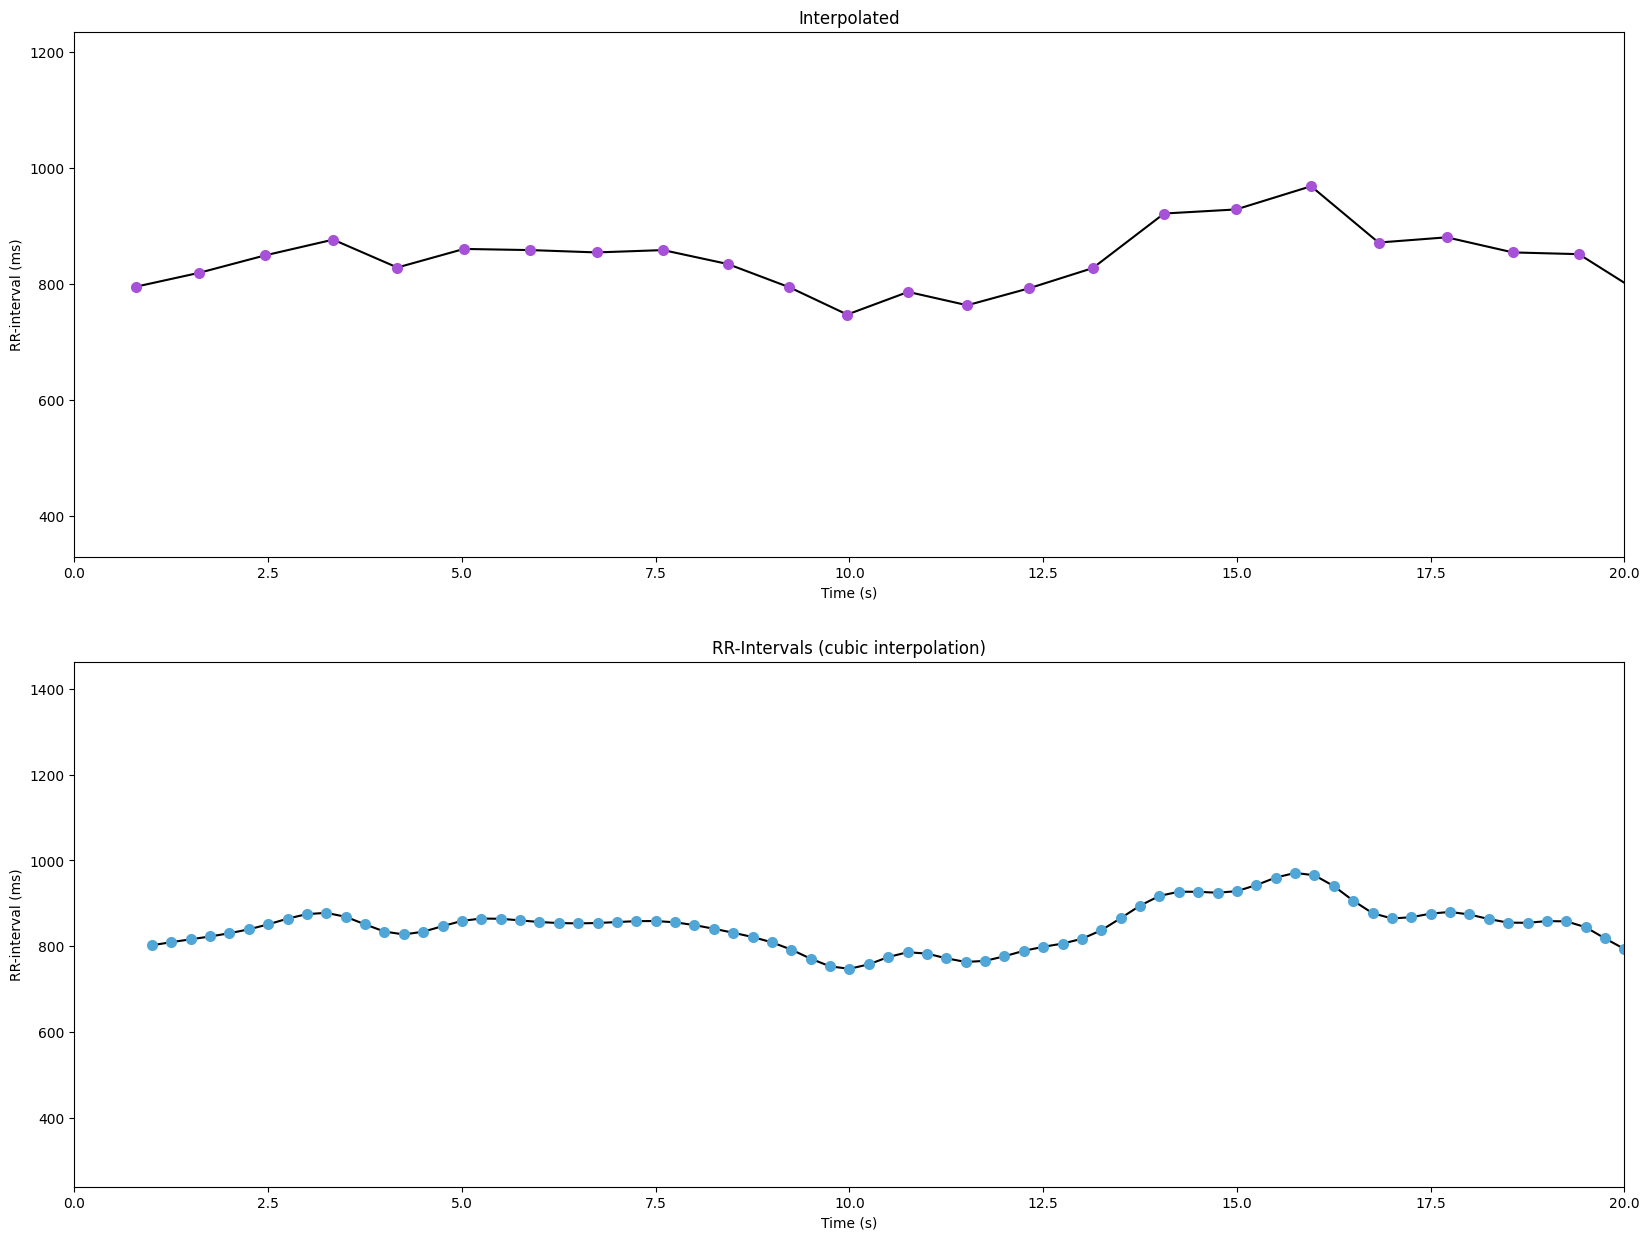

In [29]:

# create interpolation function based on the rr-samples. 
x = np.cumsum(rr_corrected) / 1000.0
f = interp1d(x, rr_corrected, kind='cubic')

# sample rate for interpolation
fs = 4.0
steps = 1 / fs

# now we can sample from interpolation function
xx = np.arange(1, np.max(x), steps)
rr_interpolated = f(xx)
plt.figure(figsize=(20, 15))

plt.subplot(211)
plt.title("RR intervals")
plt.plot(x, rr_corrected, color="k", markerfacecolor="#A651D8", markeredgewidth=0, marker="o", markersize=8)
plt.xlabel("Time (s)")
plt.ylabel("RR-interval (ms)")
plt.title("Interpolated")
plt.gca().set_xlim(0, 20)

plt.subplot(212)
plt.title("RR-Intervals (cubic interpolation)")
plt.plot(xx, rr_interpolated, color="k", markerfacecolor="#51A6D8", markeredgewidth=0, marker="o", markersize=8)
plt.gca().set_xlim(0, 20)
plt.xlabel("Time (s)")
plt.ylabel("RR-interval (ms)")
plt.show()

In [30]:
def frequency_domain(rri, fs=4):
    # Estimate the spectral density using Welch's method
    fxx, pxx = signal.welch(x=rr_interpolated, fs=fs)
    
    '''
    Segement found frequencies in the bands 
     - Very Low Frequency (VLF): 0-0.04Hz 
     - Low Frequency (LF): 0.04-0.15Hz 
     - High Frequency (HF): 0.15-0.4Hz
    '''
    cond_vlf = (fxx >= 0) & (fxx < 0.04)
    cond_lf = (fxx >= 0.04) & (fxx < 0.15)
    cond_hf = (fxx >= 0.15) & (fxx < 0.4)
    
    # calculate power in each band by integrating the spectral density 
    vlf = trapz(pxx[cond_vlf], fxx[cond_vlf])
    lf = trapz(pxx[cond_lf], fxx[cond_lf])
    hf = trapz(pxx[cond_hf], fxx[cond_hf])
    
    # sum these up to get total power
    total_power = vlf + lf + hf

    # find which frequency has the most power in each band
    peak_vlf = fxx[cond_vlf][np.argmax(pxx[cond_vlf])]
    peak_lf = fxx[cond_lf][np.argmax(pxx[cond_lf])]
    peak_hf = fxx[cond_hf][np.argmax(pxx[cond_hf])]

    # fraction of lf and hf
    lf_nu = 100 * lf / (lf + hf)
    hf_nu = 100 * hf / (lf + hf)
    
    results = {}
    results['Power VLF (ms2)'] = vlf
    results['Power LF (ms2)'] = lf
    results['Power HF (ms2)'] = hf   
    results['Power Total (ms2)'] = total_power

    results['LF/HF'] = (lf/hf)
    results['Peak VLF (Hz)'] = peak_vlf
    results['Peak LF (Hz)'] = peak_lf
    results['Peak HF (Hz)'] = peak_hf

    results['Fraction LF (nu)'] = lf_nu
    results['Fraction HF (nu)'] = hf_nu
    return results, fxx, pxx

In [31]:
print("Frequency domain metrics:")
results, fxx, pxx = frequency_domain(rr_interpolated)

for k, v in results.items():
    print("- %s: %.2f" % (k, v))

Frequency domain metrics:
- Power VLF (ms2): 1185.87
- Power LF (ms2): 1121.69
- Power HF (ms2): 794.56
- Power Total (ms2): 3102.12
- LF/HF: 1.41
- Peak VLF (Hz): 0.02
- Peak LF (Hz): 0.05
- Peak HF (Hz): 0.16
- Fraction LF (nu): 58.54
- Fraction HF (nu): 41.46


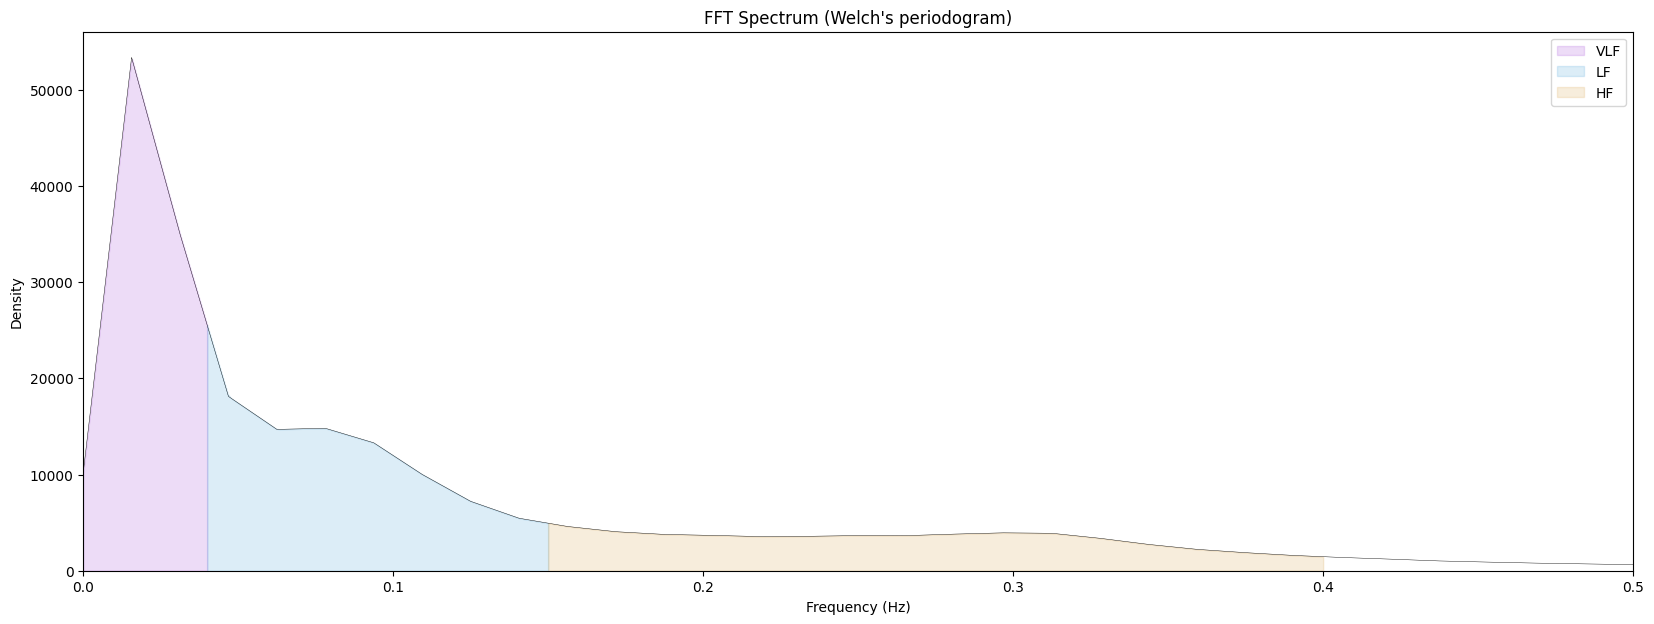

In [32]:
plt.figure(figsize=(20, 7))
plt.plot(fxx, pxx, color="k", linewidth=0.3)
plt.title("FFT Spectrum (Welch's periodogram)")

# create interpolation function for plotting frequency bands
psd_f = interp1d(fxx, pxx)

# setup frequency bands for plotting
x_vlf = np.linspace(0, 0.04, 100)
x_lf = np.linspace(0.04, 0.15, 100)
x_hf = np.linspace(0.15, 0.4, 100)

plt.gca().fill_between(x_vlf, psd_f(x_vlf), alpha=0.2, color="#A651D8", label="VLF")
plt.gca().fill_between(x_lf, psd_f(x_lf), alpha=0.2, color="#51A6D8", label="LF")
plt.gca().fill_between(x_hf, psd_f(x_hf), alpha=0.2, color="#D8A651", label="HF")

plt.gca().set_xlim(0, 0.5)
plt.gca().set_ylim(0)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Density")
plt.legend()
plt.show()

SD1: 0.000 ms
SD2: 172.168 ms


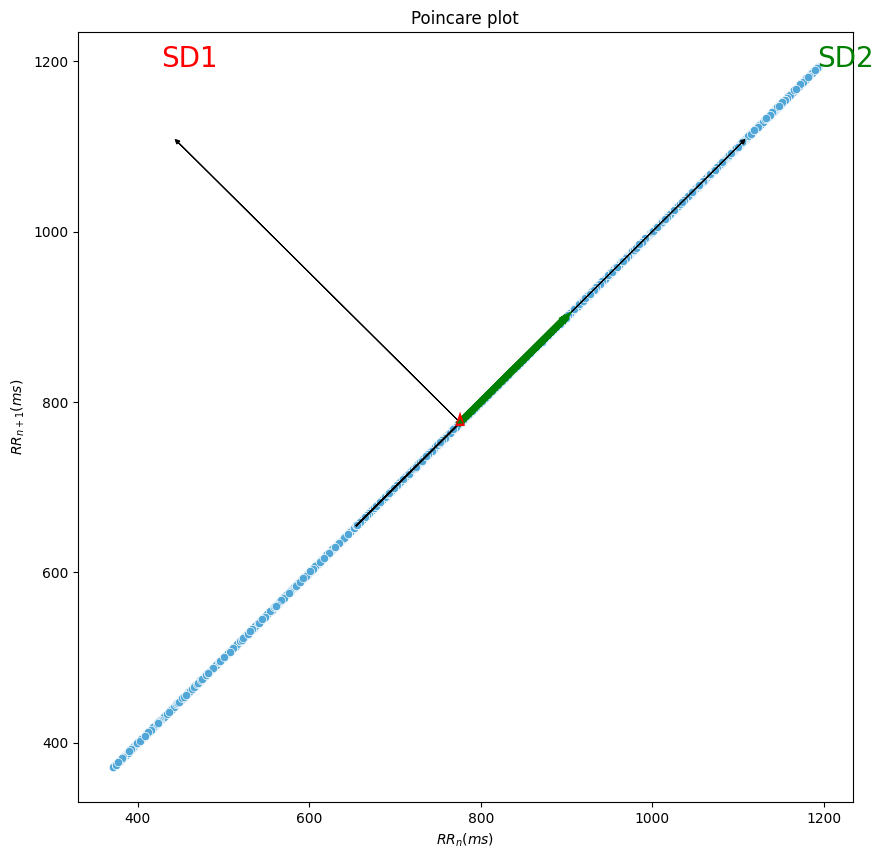

In [33]:
def plot_poincare(rr):
    rr_n = rr[:-1]
    rr_n1 = rr[1:]

    sd1 = np.sqrt(0.5) * np.std(rr_n1 - rr_n)
    sd2 = np.sqrt(0.5) * np.std(rr_n1 + rr_n)

    m = np.mean(rr)
    min_rr = np.min(rr)
    max_rr = np.max(rr)
    
    plt.figure(figsize=(10, 10))
    plt.title("Poincare plot")

    sns.scatterplot(x=rr_n, y=rr_n1, color="#51A6D8")

    plt.xlabel(r'$RR_n (ms)$')
    plt.ylabel(r'$RR_{n+1} (ms)$')

    e1 = Ellipse((m, m), 2*sd1, 2*sd2, angle=-45, linewidth=1.2, fill=False, color="k")
    plt.gca().add_patch(e1)

    plt.arrow(m, m, (max_rr-min_rr)*0.4, (max_rr-min_rr)*0.4, color="k", linewidth=0.8, head_width=5, head_length=5)
    plt.arrow(m, m, (min_rr-max_rr)*0.4, (max_rr-min_rr)*0.4, color="k", linewidth=0.8, head_width=5, head_length=5)

    plt.arrow(m, m, sd2 * np.sqrt(0.5), sd2 * np.sqrt(0.5), color="green", linewidth=5)
    plt.arrow(m, m, -sd1 * np.sqrt(0.5), sd1 * np.sqrt(0.5), color="red", linewidth=5)

    plt.text(max_rr, max_rr, "SD2", fontsize=20, color="green")
    plt.text(m-(max_rr-min_rr)*0.4-20, max_rr, "SD1", fontsize=20, color="red")
    
    return sd1, sd2

sd1, sd2 = plot_poincare(rr_corrected)
print("SD1: %.3f ms" % sd1)
print("SD2: %.3f ms" % sd2)